In [123]:
import pandas as pd
import glob
import time
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

バリデーションの方法をこれにしたらいきなりLB13台が出て焦った。  
seed変えて提出したらたいしたことないスコアになってたので、  
たまたまpublicでいいスコアを踏んだだけだと思ってあんまり信頼してなかった。

In [2]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.050,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [110]:
df_train = pd.DataFrame()
train_features_path = ['../features/train__200__important_columns.pkl',
                       '../features/train__201__rolling_mean_per_FlightRegime.pkl',
                       '../features/train__004__cumsum_per_FlightRegime.pkl',
                       '../features/train__005__count_FlightRegime.pkl'
                       ]
for file_path in train_features_path:
    print(file_path)
    df_tmp = pd.read_pickle(file_path)
    df_train = pd.concat([df_train, df_tmp], axis=1)

../features/train__200__important_columns.pkl
../features/train__201__rolling_mean_per_FlightRegime.pkl
../features/train__004__cumsum_per_FlightRegime.pkl
../features/train__005__count_FlightRegime.pkl


In [111]:
df_test = pd.DataFrame()
test_features_path = ['../features/test__200__important_columns.pkl',
                       '../features/test__201__rolling_mean_per_FlightRegime.pkl',
                       '../features/test__004__cumsum_per_FlightRegime.pkl',
                       '../features/test__005__count_FlightRegime.pkl'
                       ]
for file_path in test_features_path:
    df_tmp = pd.read_pickle(file_path)
    df_test = pd.concat([df_test, df_tmp], axis=1)

In [7]:
target = pd.read_pickle('../features/target__000__raw_data.pkl')

In [73]:
Engine_list_sort_by_length = list(df_train.EngineID.value_counts().index)
folds_EngineID = []
folds_EngineID.append(Engine_list_sort_by_length[0::10])
folds_EngineID.append(Engine_list_sort_by_length[1::10])
folds_EngineID.append(Engine_list_sort_by_length[2::10])
folds_EngineID.append(Engine_list_sort_by_length[3::10])
folds_EngineID.append(Engine_list_sort_by_length[4::10])
folds_EngineID.append(Engine_list_sort_by_length[5::10])
folds_EngineID.append(Engine_list_sort_by_length[6::10])
folds_EngineID.append(Engine_list_sort_by_length[7::10])
folds_EngineID.append(Engine_list_sort_by_length[8::10])
folds_EngineID.append(Engine_list_sort_by_length[9::10])

In [112]:
features = [c for c in df_train.columns if c not in ['Flight Regime', 'EngineID', 'EngineIndex']]
categorical_feats = []

In [113]:
predictions = np.zeros(len(df_test))
start = time.time()
feature_importance_list = []

In [ ]:
test_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values - 1
test_lastidx = list(test_lastidx)

In [114]:
oof = df_train[['EngineID', 'EngineIndex', 'Flight Regime']]
oof = pd.concat([oof, target[['lifespan']]], axis=1)
oof['prediction'] = np.nan
oof = oof[oof['EngineIndex'].isin(test_lastidx)]

In [115]:
num_round = 1000

In [118]:
train_idx = []
for i in range(10):
    print(i)
    train_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values - i
    train_idx.extend(list(train_lastidx))
    train_lastidx = df_test.groupby('EngineID').count().iloc[:, 0].values + i
    train_idx.extend(list(train_lastidx))

0
1
2
3
4
5
6
7
8
9


In [119]:
train_idx = set(train_idx)

In [120]:
predictions = np.zeros(len(df_test))
for fr in tqdm(np.sort(df_train['Flight Regime'].unique())):
    df_train_fr = df_train[df_train['Flight Regime'] == fr]
    df_test_fr = df_test[df_test['Flight Regime'] == fr]
    target_fr = target[target['Flight Regime'] == fr][['lifespan', 'EngineID', 'EngineIndex']]
    feature_importance_df = pd.DataFrame()
    for fold_ in range(10):
        print("fold n°{}".format(fold_))
        val_ID = folds_EngineID[fold_]        
        trn_data = lgb.Dataset(df_train_fr[(~(df_train_fr['EngineID'].isin(val_ID))) &
                                           (df_train_fr['EngineIndex'].isin(train_idx))][features],
                               label=target_fr[(~(target_fr['EngineID'].isin(val_ID))) &
                                               (target_fr['EngineIndex'].isin(train_idx))]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        # testデータで予測するindexのみをval_dataで用いる
        # こうすることで、val_dataとtest_dataの分布が近づくことを狙っている
        val_data = lgb.Dataset(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                           (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                               label=target_fr[target_fr['EngineID'].isin(val_ID) &
                                               target_fr['EngineIndex'].isin(test_lastidx)]['lifespan'],
                               categorical_feature=categorical_feats
                               )
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=100,
                        early_stopping_rounds=200)
        
        val_pre =clf.predict(df_train_fr[(df_train_fr['EngineID'].isin(val_ID)) & 
                                         (df_train_fr['EngineIndex'].isin(test_lastidx))][features],
                             num_iteration=clf.best_iteration)
        
        oof.loc[(oof['Flight Regime'] == fr) &
                (oof['EngineID'].isin(val_ID)) & 
                (oof['EngineIndex'].isin(test_lastidx)), 'prediction'] = val_pre
        
        predictions[df_test_fr.index] += clf.predict(df_test_fr[features], num_iteration=clf.best_iteration) / 10


  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.5324	valid_1's l1: 27.871
[200]	training's l1: 14.8651	valid_1's l1: 27.5368
[300]	training's l1: 13.0864	valid_1's l1: 27.5341
[400]	training's l1: 11.8089	valid_1's l1: 27.6204
Early stopping, best iteration is:
[253]	training's l1: 13.8521	valid_1's l1: 27.3649
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.632	valid_1's l1: 20.7492
[200]	training's l1: 14.7134	valid_1's l1: 20.9637
[300]	training's l1: 12.9267	valid_1's l1: 21.3074
Early stopping, best iteration is:
[135]	training's l1: 16.4689	valid_1's l1: 20.5382
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.5066	valid_1's l1: 25.1925
[200]	training's l1: 14.7229	valid_1's l1: 25.5161
[300]	training's l1: 13.0315	valid_1's l1: 25.7295
Early stopping, best iteration is:
[109]	training's l1: 17.2017	valid_1's l1: 25.0425
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.7943	valid_1's l1: 23.3098
[200]	training's l1: 15.0254	valid_1's l1: 22.8065
[300]	training's l1: 13.368	valid_1's l1: 22.816
[400]	training's l1: 12.0422	valid_1's l1: 23.2916
Early stopping, best iteration is:
[222]	training's l1: 14.6258	valid_1's l1: 22.6539
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.6103	valid_1's l1: 27.4255
[200]	training's l1: 14.7901	valid_1's l1: 26.722
[300]	training's l1: 13.2737	valid_1's l1: 26.8782
[400]	training's l1: 11.8485	valid_1's l1: 26.6944
[500]	training's l1: 10.8012	valid_1's l1: 26.6346
[600]	training's l1: 9.95612	valid_1's l1: 26.5553
[700]	training's l1: 9.22302	valid_1's l1: 26.5018
[800]	training's l1: 8.6108	valid_1's l1: 26.3666
[900]	training's l1: 8.05736	valid_1's l1: 26.3437
[1000]	training's l1: 7.5542	valid_1's l1: 26.287
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 7.5542	valid_1's l1: 26.287
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.7295	valid_1's l1: 22.7598
[200]	training's l1: 15.0042	valid_1's l1: 22.2382
[300]	training's l1: 13.3251	valid_1's l1: 22.1642
[400]	training's l1: 11.9921	valid_1's l1: 22.3772
Early stopping, best iteration is:
[281]	training's l1: 13.5933	valid_1's l1: 22.0456
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.7947	valid_1's l1: 21.3462
[200]	training's l1: 15.0947	valid_1's l1: 21.6479
Early stopping, best iteration is:
[82]	training's l1: 18.5768	valid_1's l1: 21.093
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.6461	valid_1's l1: 24.5453
[200]	training's l1: 14.8971	valid_1's l1: 24.0021
[300]	training's l1: 13.1554	valid_1's l1: 24.3752
[400]	training's l1: 11.8066	valid_1's l1: 24.5133
Early stopping, best iteration is:
[200]	training's l1: 14.8971	valid_1's l1: 24.0021
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.5729	valid_1's l1: 22.251
[200]	training's l1: 14.9461	valid_1's l1: 22.7161
[300]	training's l1: 13.2247	valid_1's l1: 22.6564
Early stopping, best iteration is:
[104]	training's l1: 17.4259	valid_1's l1: 22.1862
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.7226	valid_1's l1: 24.5184
[200]	training's l1: 15.0867	valid_1's l1: 24.7192
[300]	training's l1: 13.2483	valid_1's l1: 24.65
Early stopping, best iteration is:
[136]	training's l1: 16.5656	valid_1's l1: 24.339



 17%|██████████████                                                                      | 1/6 [01:16<06:21, 76.34s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.3074	valid_1's l1: 28.556
[200]	training's l1: 14.3516	valid_1's l1: 28.426
[300]	training's l1: 12.6207	valid_1's l1: 28.54
Early stopping, best iteration is:
[173]	training's l1: 14.9856	valid_1's l1: 28.2521
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.762	valid_1's l1: 25.3672
[200]	training's l1: 14.7595	valid_1's l1: 25.2122
[300]	training's l1: 13.0317	valid_1's l1: 25.272
Early stopping, best iteration is:
[133]	training's l1: 16.5572	valid_1's l1: 24.939
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.5682	valid_1's l1: 27.6106
[200]	training's l1: 14.775	valid_1's l1: 27.714
Early stopping, best iteration is:
[97]	training's l1: 17.6607	valid_1's l1: 27.51
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.7196	valid_1's l1: 24.8628
[200]	training's l1: 14.8919	valid_1's l1: 24.3117
[300]	training's l1: 13.206	valid_1's l1: 24.2201
[400]	training's l1: 11.8345	valid_1's l1: 24.1309
[500]	training's l1: 10.8572	valid_1's l1: 24.1438
Early stopping, best iteration is:
[347]	training's l1: 12.485	valid_1's l1: 23.9456
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.4755	valid_1's l1: 29.8839
[200]	training's l1: 14.6761	valid_1's l1: 30.068
Early stopping, best iteration is:
[89]	training's l1: 17.9723	valid_1's l1: 29.6976
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.3442	valid_1's l1: 28.9032
[200]	training's l1: 14.622	valid_1's l1: 29.3016
[300]	training's l1: 12.9302	valid_1's l1: 29.5482
Early stopping, best iteration is:
[108]	training's l1: 17.0105	valid_1's l1: 28.7082
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.9601	valid_1's l1: 23.5888
[200]	training's l1: 14.9942	valid_1's l1: 23.865
[300]	training's l1: 13.2329	valid_1's l1: 24.0749
Early stopping, best iteration is:
[103]	training's l1: 17.833	valid_1's l1: 23.4897
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.0232	valid_1's l1: 23.3133
[200]	training's l1: 15.1979	valid_1's l1: 23.2126
[300]	training's l1: 13.3553	valid_1's l1: 23.43
Early stopping, best iteration is:
[152]	training's l1: 16.2764	valid_1's l1: 23.0405
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.9091	valid_1's l1: 21.7414
[200]	training's l1: 15.0097	valid_1's l1: 21.9071
[300]	training's l1: 13.2665	valid_1's l1: 22.2212
Early stopping, best iteration is:
[127]	training's l1: 16.8912	valid_1's l1: 21.4005
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.9904	valid_1's l1: 24.0069
[200]	training's l1: 15.2632	valid_1's l1: 23.7672
[300]	training's l1: 13.5422	valid_1's l1: 23.727
[400]	training's l1: 12.3286	valid_1's l1: 23.8079
Early stopping, best iteration is:
[220]	training's l1: 14.8411	valid_1's l1: 23.6156



 33%|████████████████████████████                                                        | 2/6 [02:22<04:52, 73.24s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.4777	valid_1's l1: 31.5906
[200]	training's l1: 14.6972	valid_1's l1: 31.604
[300]	training's l1: 13.0995	valid_1's l1: 31.8559
Early stopping, best iteration is:
[113]	training's l1: 16.9711	valid_1's l1: 31.3316
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.9996	valid_1's l1: 26.0495
[200]	training's l1: 14.8869	valid_1's l1: 26.0997
[300]	training's l1: 13.1289	valid_1's l1: 25.7237
[400]	training's l1: 11.7909	valid_1's l1: 25.8294
[500]	training's l1: 10.6546	valid_1's l1: 25.8195
Early stopping, best iteration is:
[323]	training's l1: 12.8315	valid_1's l1: 25.6304
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.961	valid_1's l1: 23.0832
[200]	training's l1: 14.8509	valid_1's l1: 22.5778
[300]	training's l1: 12.9924	valid_1's l1: 22.642
[400]	training's l1: 11.6885	valid_1's l1: 22.9776
Early stopping, best iteration is:
[253]	training's l1: 13.8609	valid_1's l1: 22.5434
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.8801	valid_1's l1: 24.2437
[200]	training's l1: 14.8909	valid_1's l1: 24.1028
[300]	training's l1: 13.0969	valid_1's l1: 24.5912
Early stopping, best iteration is:
[196]	training's l1: 14.9709	valid_1's l1: 24.0469
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.66	valid_1's l1: 28.1236
[200]	training's l1: 14.62	valid_1's l1: 27.8286
[300]	training's l1: 12.6968	valid_1's l1: 27.9343
Early stopping, best iteration is:
[179]	training's l1: 15.1214	valid_1's l1: 27.7207
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.8313	valid_1's l1: 27.0612
[200]	training's l1: 14.7718	valid_1's l1: 26.4896
[300]	training's l1: 12.964	valid_1's l1: 26.8096
Early stopping, best iteration is:
[160]	training's l1: 15.717	valid_1's l1: 26.4096
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.1315	valid_1's l1: 23.3879
[200]	training's l1: 15.0983	valid_1's l1: 23.3462
[300]	training's l1: 13.1624	valid_1's l1: 23.4685
Early stopping, best iteration is:
[113]	training's l1: 17.6036	valid_1's l1: 23.2533
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.9972	valid_1's l1: 23.8229
[200]	training's l1: 14.9403	valid_1's l1: 23.1415
[300]	training's l1: 13.0539	valid_1's l1: 23.2441
[400]	training's l1: 11.7833	valid_1's l1: 23.2897
Early stopping, best iteration is:
[218]	training's l1: 14.5504	valid_1's l1: 23.0496
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.2948	valid_1's l1: 21.4785
[200]	training's l1: 15.3898	valid_1's l1: 21.8894
Early stopping, best iteration is:
[86]	training's l1: 18.9838	valid_1's l1: 21.4365
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.0511	valid_1's l1: 22.3774
[200]	training's l1: 15.0536	valid_1's l1: 21.8665
[300]	training's l1: 13.0967	valid_1's l1: 22.1208
Early stopping, best iteration is:
[167]	training's l1: 15.8194	valid_1's l1: 21.7568



 50%|██████████████████████████████████████████                                          | 3/6 [03:30<03:35, 71.82s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.9028	valid_1's l1: 25.9794
[200]	training's l1: 14.8474	valid_1's l1: 25.766
[300]	training's l1: 12.8189	valid_1's l1: 25.9911
[400]	training's l1: 11.4589	valid_1's l1: 26.1402
Early stopping, best iteration is:
[234]	training's l1: 14.055	valid_1's l1: 25.6824
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.8863	valid_1's l1: 25.5842
[200]	training's l1: 14.8305	valid_1's l1: 26.0184
Early stopping, best iteration is:
[88]	training's l1: 18.6001	valid_1's l1: 25.3252
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.8165	valid_1's l1: 25.8838
[200]	training's l1: 14.8413	valid_1's l1: 25.739
[300]	training's l1: 12.9127	valid_1's l1: 25.3122
[400]	training's l1: 11.5437	valid_1's l1: 25.2069
[500]	training's l1: 10.4338	valid_1's l1: 25.1952
[600]	training's l1: 9.4794	valid_1's l1: 25.1478
[700]	training's l1: 8.6632	valid_1's l1: 25.2622
Early stopping, best iteration is:
[580]	training's l1: 9.66035	valid_1's l1: 25.0532
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.1283	valid_1's l1: 26.8507
[200]	training's l1: 14.8731	valid_1's l1: 26.0922
[300]	training's l1: 13.0014	valid_1's l1: 25.9203
[400]	training's l1: 11.594	valid_1's l1: 25.6344
[500]	training's l1: 10.4733	valid_1's l1: 25.5301
[600]	training's l1: 9.52411	valid_1's l1: 25.659
Early stopping, best iteration is:
[493]	training's l1: 10.5368	valid_1's l1: 25.5279
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.6183	valid_1's l1: 26.7139
[200]	training's l1: 14.4781	valid_1's l1: 26.8932
Early stopping, best iteration is:
[88]	training's l1: 18.2934	valid_1's l1: 26.5152
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.7321	valid_1's l1: 29.5602
[200]	training's l1: 14.5749	valid_1's l1: 29.9982
Early stopping, best iteration is:
[98]	training's l1: 17.8726	valid_1's l1: 29.4957
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.1875	valid_1's l1: 24.4109
[200]	training's l1: 14.9554	valid_1's l1: 23.7712
[300]	training's l1: 13.0686	valid_1's l1: 23.9161
Early stopping, best iteration is:
[180]	training's l1: 15.4372	valid_1's l1: 23.6623
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.8924	valid_1's l1: 24.7151
[200]	training's l1: 14.8509	valid_1's l1: 25.2953
Early stopping, best iteration is:
[96]	training's l1: 18.0862	valid_1's l1: 24.5964
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.2305	valid_1's l1: 21.9928
[200]	training's l1: 15.1229	valid_1's l1: 22.371
[300]	training's l1: 13.2659	valid_1's l1: 22.6719
Early stopping, best iteration is:
[121]	training's l1: 17.3673	valid_1's l1: 21.8632
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 17.8965	valid_1's l1: 23.9001
[200]	training's l1: 14.7539	valid_1's l1: 23.7556
[300]	training's l1: 12.95	valid_1's l1: 23.3912
[400]	training's l1: 11.5984	valid_1's l1: 23.4135
[500]	training's l1: 10.5602	valid_1's l1: 23.3344
[600]	training's l1: 9.64684	valid_1's l1: 23.1954
[700]	training's l1: 8.88582	valid_1's l1: 23.1636
[800]	training's l1: 8.20257	valid_1's l1: 23.1353
[900]	training's l1: 7.65232	valid_1's l1: 23.1064
[1000]	training's l1: 7.15442	valid_1's l1: 23.1486
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 7.15442	valid_1's l1: 23.1486



 67%|████████████████████████████████████████████████████████                            | 4/6 [04:57<02:32, 76.36s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.3403	valid_1's l1: 30.2742
[200]	training's l1: 15.1897	valid_1's l1: 30.465
Early stopping, best iteration is:
[89]	training's l1: 18.8357	valid_1's l1: 30.0959
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.546	valid_1's l1: 27.8203
[200]	training's l1: 15.2688	valid_1's l1: 28.1719
Early stopping, best iteration is:
[79]	training's l1: 19.5701	valid_1's l1: 27.2976
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.5631	valid_1's l1: 25.7733
[200]	training's l1: 15.439	valid_1's l1: 26.1944
Early stopping, best iteration is:
[86]	training's l1: 19.2558	valid_1's l1: 25.6599
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.5181	valid_1's l1: 26.6273
[200]	training's l1: 15.3571	valid_1's l1: 26.2008
[300]	training's l1: 13.3624	valid_1's l1: 26.3689
Early stopping, best iteration is:
[176]	training's l1: 15.9575	valid_1's l1: 26.1157
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.4895	valid_1's l1: 27.571
[200]	training's l1: 15.3052	valid_1's l1: 27.6925
Early stopping, best iteration is:
[71]	training's l1: 19.938	valid_1's l1: 27.2326
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.3757	valid_1's l1: 25.9524
[200]	training's l1: 15.2612	valid_1's l1: 26.0316
[300]	training's l1: 13.2767	valid_1's l1: 26.0585
Early stopping, best iteration is:
[124]	training's l1: 17.4643	valid_1's l1: 25.7968
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.7725	valid_1's l1: 25.8732
[200]	training's l1: 15.6068	valid_1's l1: 26.4177
Early stopping, best iteration is:
[53]	training's l1: 21.9278	valid_1's l1: 25.3594
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.5741	valid_1's l1: 27.2966
[200]	training's l1: 15.4333	valid_1's l1: 26.9819
[300]	training's l1: 13.4164	valid_1's l1: 27.0654
Early stopping, best iteration is:
[161]	training's l1: 16.4407	valid_1's l1: 26.8058
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.6281	valid_1's l1: 23.1573
[200]	training's l1: 15.5941	valid_1's l1: 23.5373
[300]	training's l1: 13.5878	valid_1's l1: 24.0536
Early stopping, best iteration is:
[121]	training's l1: 17.8785	valid_1's l1: 23.0465
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 18.3537	valid_1's l1: 29.6868
[200]	training's l1: 15.3187	valid_1's l1: 30.0851
Early stopping, best iteration is:
[86]	training's l1: 18.9808	valid_1's l1: 29.4952



 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [05:56<01:11, 71.08s/it]

fold n°0


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.2099	valid_1's l1: 28.4553
[200]	training's l1: 13.3478	valid_1's l1: 28.4816
[300]	training's l1: 11.372	valid_1's l1: 28.5414
Early stopping, best iteration is:
[111]	training's l1: 15.8107	valid_1's l1: 28.3005
fold n°1


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.2395	valid_1's l1: 26.7345
[200]	training's l1: 13.1025	valid_1's l1: 27.3558
Early stopping, best iteration is:
[60]	training's l1: 19.0306	valid_1's l1: 26.4467
fold n°2


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.325	valid_1's l1: 27.7766
[200]	training's l1: 13.4274	valid_1's l1: 27.8461
Early stopping, best iteration is:
[81]	training's l1: 17.1852	valid_1's l1: 27.5587
fold n°3


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.6258	valid_1's l1: 23.968
[200]	training's l1: 13.503	valid_1's l1: 23.1096
[300]	training's l1: 11.4751	valid_1's l1: 22.9233
[400]	training's l1: 10.2969	valid_1's l1: 22.8172
[500]	training's l1: 9.09257	valid_1's l1: 22.7119
[600]	training's l1: 8.19021	valid_1's l1: 22.6608
[700]	training's l1: 7.46167	valid_1's l1: 22.68
Early stopping, best iteration is:
[588]	training's l1: 8.28131	valid_1's l1: 22.626
fold n°4


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.2322	valid_1's l1: 26.8399
[200]	training's l1: 13.3728	valid_1's l1: 26.2493
[300]	training's l1: 11.4719	valid_1's l1: 26.1405
[400]	training's l1: 10.0942	valid_1's l1: 25.9972
[500]	training's l1: 9.02147	valid_1's l1: 25.9104
[600]	training's l1: 8.20878	valid_1's l1: 25.8445
[700]	training's l1: 7.39801	valid_1's l1: 25.8437
[800]	training's l1: 6.77168	valid_1's l1: 25.8294
[900]	training's l1: 6.18385	valid_1's l1: 25.7372
[1000]	training's l1: 5.773	valid_1's l1: 25.7655
Did not meet early stopping. Best iteration is:
[1000]	training's l1: 5.773	valid_1's l1: 25.7655
fold n°5


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.2405	valid_1's l1: 29.6022
[200]	training's l1: 13.2582	valid_1's l1: 29.551
[300]	training's l1: 11.456	valid_1's l1: 29.5494
Early stopping, best iteration is:
[105]	training's l1: 16.0345	valid_1's l1: 29.4593
fold n°6


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.5845	valid_1's l1: 25.9654
[200]	training's l1: 13.4973	valid_1's l1: 26.974
Early stopping, best iteration is:
[59]	training's l1: 19.277	valid_1's l1: 25.3489
fold n°7


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.5577	valid_1's l1: 25.3199
[200]	training's l1: 13.3476	valid_1's l1: 25.5064
Early stopping, best iteration is:
[96]	training's l1: 16.7394	valid_1's l1: 25.2247
fold n°8


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.699	valid_1's l1: 22.3676
[200]	training's l1: 13.6693	valid_1's l1: 22.5164
Early stopping, best iteration is:
[88]	training's l1: 17.2503	valid_1's l1: 22.307
fold n°9


C:\Users\linda\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 16.1891	valid_1's l1: 26.3316
[200]	training's l1: 13.1914	valid_1's l1: 26.0951
[300]	training's l1: 11.311	valid_1's l1: 26.0525
[400]	training's l1: 10.0743	valid_1's l1: 26.0792
Early stopping, best iteration is:
[237]	training's l1: 12.3945	valid_1's l1: 26.0143



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:46<00:00, 82.81s/it]


In [121]:
mean_absolute_error(oof['lifespan'], oof['prediction'])

25.30480485201604

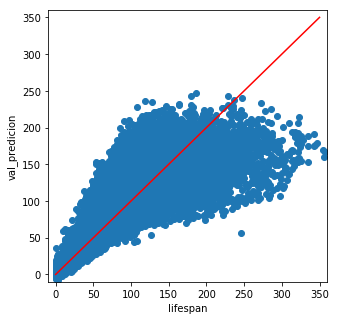

In [146]:
plt.figure(figsize=(5,5))
plt.plot(oof['lifespan'], oof['prediction'], 'o')
plt.plot(np.array([0,350]), np.array([0,350]), c='red')
plt.xlabel('lifespan')
plt.ylabel('val_predicion')
plt.xlim([-10, 360])
plt.ylim([-10, 360]);

lifespan 100より多いときさらに正解率下がるよね

In [135]:
# submit
sub_df = pd.DataFrame({"Predicted RUL": predictions, 'EngineID': df_test['EngineID']})
# 必要なのは各エンジンの最後の行のみ
sub_df = sub_df[sub_df['EngineID'].astype('category').cat.codes.diff(-1) != 0]
del sub_df['EngineID']

In [141]:
sub_df.to_csv('C0003_14_04_2019.csv', index=False)